In [1]:
from typing import Dict, Tuple
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML

import importlib.util
import sys

# Define the path to your script
utils_path = '/kaggle/input/kyrises-rpg-icon-pack/diffusion_utilities.py'

# Load the module
spec = importlib.util.spec_from_file_location("utils", utils_path)
utils = importlib.util.module_from_spec(spec)
sys.modules["utils"] = utils
spec.loader.exec_module(utils)
from utils import *

In [2]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]
        
         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample  
            nn.GroupNorm(8, 2 * n_feat), # normalize                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]
        
        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)
        
        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
            
        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [3]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image

# training hyperparameters
batch_size = 100
n_epoch = 48
lrate=1e-3

In [4]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [5]:
# set neural network
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

dataset = CustomDataset("/kaggle/input/kyrises-rpg-icon-pack/sprites_1788_16x16.npy", "/kaggle/input/kyrises-rpg-icon-pack/sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [6]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [7]:
# training with context code
# set into train mode
nn_model.train()

for ep in range(1,n_epoch+1):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2)
    running_loss = 0
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps, c=c)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise, reduction='sum')
        loss.backward()
        
        optim.step()
        running_loss += loss.item()
    print(f"epoch: {ep}", f"Training loss: {running_loss/89400}")

epoch 1


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 1 Training loss: 227.43343991409745
epoch 2


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 2 Training loss: 161.0819249969414
epoch 3


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 3 Training loss: 141.89021708307118
epoch 4


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 4 Training loss: 131.82932071011606
epoch 5


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 5 Training loss: 124.43088496334067
epoch 6


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 6 Training loss: 118.12941496915198
epoch 7


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 7 Training loss: 114.4721318992939
epoch 8


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 8 Training loss: 109.74187745232977
epoch 9


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 9 Training loss: 106.60437162463298
epoch 10


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 10 Training loss: 102.44650674636465
epoch 11


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 11 Training loss: 101.3089929554233
epoch 12


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 12 Training loss: 99.10210227471336
epoch 13


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 13 Training loss: 96.7600546012042
epoch 14


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 14 Training loss: 94.65910613399224
epoch 15


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 15 Training loss: 93.79538702570085
epoch 16


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 16 Training loss: 92.31815033163801
epoch 17


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 17 Training loss: 90.13107956035026
epoch 18


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 18 Training loss: 90.01182383970392
epoch 19


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 19 Training loss: 86.95424862035969
epoch 20


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 20 Training loss: 87.16680163219205
epoch 21


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 21 Training loss: 85.97531902134018
epoch 22


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 22 Training loss: 85.04666639357872
epoch 23


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 23 Training loss: 84.45736336317638
epoch 24


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 24 Training loss: 82.75671719886046
epoch 25


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 25 Training loss: 83.35549319683305
epoch 26


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 26 Training loss: 81.20843574131362
epoch 27


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 27 Training loss: 80.7157338583176
epoch 28


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 28 Training loss: 79.83685422346896
epoch 29


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 29 Training loss: 79.92763973364094
epoch 30


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 30 Training loss: 78.35184730888213
epoch 31


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 31 Training loss: 77.57141294611647
epoch 32


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 32 Training loss: 77.47261701818547
epoch 33


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 33 Training loss: 76.31165309419568
epoch 34


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 34 Training loss: 74.96235425296246
epoch 35


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 35 Training loss: 76.50561562762165
epoch 36


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 36 Training loss: 75.62230507528488
epoch 37


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 37 Training loss: 75.01431969422889
epoch 38


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 38 Training loss: 74.4181084344851
epoch 39


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 39 Training loss: 73.40377029589625
epoch 40


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 40 Training loss: 72.30786088572252
epoch 41


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 41 Training loss: 72.4901533771148
epoch 42


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 42 Training loss: 72.24032819163345
epoch 43


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 43 Training loss: 72.04286425016603
epoch 44


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 44 Training loss: 70.95703866979953
epoch 45


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 45 Training loss: 70.27976930895642
epoch 46


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 46 Training loss: 70.76633305150658
epoch 47


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 47 Training loss: 70.69576982946204
epoch 48


  0%|          | 0/894 [00:00<?, ?it/s]

epoch: 48 Training loss: 70.6335068315681


In [8]:
# save model
torch.save(nn_model, 'diffusion_model.pth')

In [9]:
nn_model.eval() 

ContextUnet(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-0

In [10]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [11]:
# sample with context using standard algorithm
@torch.inference_mode()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [12]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

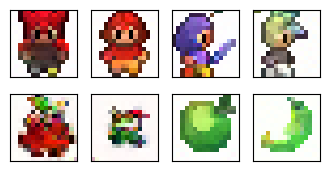

In [13]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],  
    [1,0,0,0,0],    
    [0,0,0,0,1],
    [0,0,0,0,1],    
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

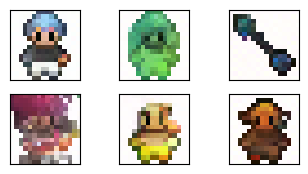

In [14]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

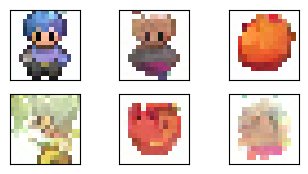

In [15]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [0,1,1,0,0],
    [1,0,1,0,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)